# RepE 相关的研究
20240320左右开始的

# 1. RepE迁移到VGG5上来看看

In [ ]:
# 导包
import torch
import os
import argparse
import pandas as pd
import tqdm
import numpy as np
# os.environ['NUMEXPR_MAX_THREADS'] = '48'

# 导入各个指标
import sys
sys.path.append('/home/dengruijun/data/FinTech/PP-Split/')
from ppsplit.quantification.distance_correlation.distCor import distCorMetric
from ppsplit.quantification.fisher_information.dFIL_inverse import dFILInverseMetric
from ppsplit.quantification.shannon_information.mutual_information import MuInfoMetric
from ppsplit.quantification.shannon_information.ULoss import ULossMetric
from ppsplit.quantification.rep_reading.rep_reader import PCA_Reader

# 导入各个baseline模型及其数据集预处理方法
# 模型
from target_model.models.splitnn_utils import split_weights_client
from target_model.models.VGG import VGG,VGG5Decoder,model_cfg
from target_model.models.BankNet import BankNet1,bank_cfg
from target_model.models.CreditNet import CreditNet1,credit_cfg
from target_model.models.PurchaseNet import PurchaseClassifier1,purchase_cfg

# 数据预处理方法
from target_model.data_preprocessing.preprocess_cifar10 import get_cifar10_normalize,deprocess
from target_model.data_preprocessing.preprocess_bank import bank_dataset,preprocess_bank
from target_model.data_preprocessing.preprocess_credit import preprocess_credit
from target_model.data_preprocessing.preprocess_purchase import preprocess_purchase
from target_model.data_preprocessing.dataset import get_one_data

# utils
from ppsplit.utils.utils import create_dir

In [ ]:
# 基本参数：
args = {
        'device':torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
        # 'device':torch.device("cpu"),
        'dataset':'CIFAR10',
        # 'dataset':'bank',
        # 'dataset':'credit',
        # 'dataset':'purchase',
        # 'result_dir': 'InvMetric-202403',
        'result_dir': '20240428-Rep-quantify/',
        'batch_size':5,
        'noise_scale':0, # 防护措施
        'num_pairs': 10000, # RepE
        }
print(args['device'])

In [ ]:
# 加载模型和数据集，并从unit模型中切割出client_model
if args['dataset']=='CIFAR10':
    # 超参数
    testset_len = 10000 # 10000个数据一次 整个测试集合的长度
    # split_layer_list = list(range(len(model_cfg['VGG5'])))
    split_layer = 6 # 定成2吧？
    test_num = 1 # 试验序号
    #  nohup python -u repE.py >> 200-split6-first10.out 2>&1  &
    # 关键路径
    # unit_net_route = '/home/dengruijun/data/FinTech/PP-Split/results/trained_models/VGG5/BN+Tanh/VGG5-params-20ep.pth' # VGG5-BN+Tanh # 存储的是模型参数，不包括模型结构
    unit_net_route = '/home/dengruijun/data/FinTech/PP-Split/results/trained_models/VGG5/20240429-RepE/VGG5-params-19ep.pth' # VGG5-BN+Tanh # 存储的是模型参数，不包括模型结构
    results_dir  = f"../results/{args['result_dir']}/VGG5/quantification/{test_num}/"

    # 数据集加载
    # trainloader,testloader = get_cifar10_normalize(batch_size = 5)
    # one_data_loader = get_one_data(testloader,batch_size = args['batch_size']) #拿到第一个测试数据

    # 切割成client model
    # vgg5_unit.load_state_dict(torch.load(unit_net_route,map_location=torch.device('cpu'))) # 完整的模型
    client_net = VGG('Client','VGG5',split_layer,model_cfg,noise_scale=args['noise_scale'])
    pweights = torch.load(unit_net_route)
    if split_layer < len(model_cfg['VGG5']):
        pweights = split_weights_client(pweights,client_net.state_dict())
    client_net.load_state_dict(pweights)

elif args['dataset']=='bank':
    # 超参数
    test_num = 1 # 试验序号
    testset_len=8238
    # split_layer_list = ['linear1', 'linear2']
    split_layer_list = [0,2,4,6]
    split_layer = 2

    # 关键路径
    results_dir  = f"../results/{args['result_dir']}/Bank/quantification/{test_num}/"
    unit_net_route = '/home/dengruijun/data/FinTech/PP-Split/results/trained_models/Bank/bank-20ep_params.pth'
    decoder_route = f"../results/{args['result_dir']}/Bank/{test_num}/Decoder-layer{split_layer}.pth"

    # 数据集加载
    trainloader,testloader = preprocess_bank(batch_size=1)
    one_data_loader = get_one_data(testloader,batch_size = args['batch_size']) #拿到第一个测试数据 

    # 模型加载
    client_net = BankNet1(layer=split_layer,noise_scale=args['noise_scale'])
    pweights = torch.load(unit_net_route)
    if split_layer < len(bank_cfg):
        pweights = split_weights_client(pweights,client_net.state_dict())
    client_net.load_state_dict(pweights)

elif args['dataset']=='credit':
    # 超参数
    test_num = 1 # 试验序号
    testset_len = 61503 # for the mutual information
    split_layer_list = [0,3,6,9]
    split_layer = 3
    # split_layer_list = ['linear1', 'linear2']

    # 关键路径
    results_dir  = f"../results/{args['result_dir']}/Credit/quantification/{test_num}/"
    unit_net_route = '/home/dengruijun/data/FinTech/PP-Split/results/trained_models/credit/credit-20ep_params.pth'
    decoder_route = f"../results/{args['result_dir']}/Credit/{test_num}/Decoder-layer{split_layer}.pth"

    # 数据集加载
    trainloader,testloader = preprocess_credit(batch_size=1)
    one_data_loader = get_one_data(testloader,batch_size = args['batch_size']) #拿到第一个测试数据

    # client模型切割加载
    client_net = CreditNet1(layer=split_layer,noise_scale=args['noise_scale'])
    pweights = torch.load(unit_net_route)
    if split_layer < len(credit_cfg):
        pweights = split_weights_client(pweights,client_net.state_dict())
    client_net.load_state_dict(pweights)

elif args['dataset']=='purchase':
    # 超参数
    test_num = 1 # 试验序号
    testset_len = 39465 # test len
    # split_layer_list = [0,1,2,3,4,5,6,7,8]
    split_layer = 3

    # 关键路径
    results_dir = f"../results/{args['result_dir']}/Purchase/quantification/{test_num}/"
    unit_net_route = '/home/dengruijun/data/FinTech/PP-Split/results/trained_models/Purchase100/Purchase_bestmodel_param.pth'
    decoder_route = f"../results/{args['result_dir']}/Purchase/{test_num}/Decoder-layer{split_layer}.pth"
    
    # 数据集加载
    trainloader,testloader = preprocess_purchase(batch_size=1)
    one_data_loader = get_one_data(testloader,batch_size = args['batch_size']) #拿到第一个测试数据

    # 模型加载
    client_net = PurchaseClassifier1(layer=split_layer,noise_scale=args['noise_scale'])
    # pweights = torch.load(unit_net_route,map_location=torch.device('cpu'))
    pweights = torch.load(unit_net_route)
    if split_layer < len(purchase_cfg):
        pweights = split_weights_client(pweights,client_net.state_dict())
    client_net.load_state_dict(pweights)

else:
    exit(-1)


In [ ]:
# client_net使用
client_net = client_net.to(args['device'])
client_net.eval()



In [ ]:
# 导包，为了数据预处理？
from target_model.data_preprocessing.dataset import pair_smashed_data,diff_pair_data
from target_model.data_preprocessing.preprocess_cifar10 import get_cifar10_normalize_two_train
import random
import time
import pickle
from torch.utils.data import DataLoader


In [ ]:
#  Picking the top X probabilities 
def clipDataTopX(dataToClip, top=3):
    sorted_indices = torch.argsort(dataToClip,dim=1,descending=True)[:,:top]
    new_data = torch.gather(dataToClip,1,sorted_indices)
    return new_data

def clipDataFirstX(dataToClip, top=3):
    new_data = dataToClip[:,:top]
    return new_data

In [ ]:
# 1. designing stimulus and test
dataset_route = f"../results/{args['result_dir']}/VGG5/quantification/{args['num_pairs']}pairs/"
if os.path.isfile(dataset_route+'train_feature.pkl'): # 直接加载预处理好的数据集
    print(f"=> loading paired dataset from {dataset_route}")
    with open(dataset_route+'train_feature.pkl','rb') as f:
        train_feature = pickle.load(file=f)       
    with open(dataset_route+'test_feature.pkl','rb') as f:
        test_feature=pickle.load(file=f)   
    with open(dataset_route+'train_label.pkl','rb') as f:                                                       
        train_labels=pickle.load(file=f)      
    with open(dataset_route+'test_label.pkl', 'rb') as f:                                                    
        test_labels=pickle.load(file=f)     
    train_loader= DataLoader(train_feature,shuffle=False,batch_size=1)
    test_loader = DataLoader(test_feature,shuffle=False,batch_size=1)       

else: # 进行预处理并存储
    seen_loader,unseen_loader,_ = get_cifar10_normalize_two_train(batch_size=1)

    train_loader,train_labels,test_loader,test_labels = pair_smashed_data(seen_loader,
                                                                        unseen_loader,
                                                                        num_pairs=args['num_pairs'])
    create_dir(dataset_route)
    with open(dataset_route+'train_feature.pkl','wb') as f:
        pickle.dump(obj=train_loader.dataset,file=f)       
    with open(dataset_route+'test_feature.pkl','wb') as f:
        pickle.dump(obj=test_loader.dataset,file=f)   
    with open(dataset_route+'train_label.pkl','wb') as f:                                                       
        pickle.dump(obj=train_labels,file=f)      
    with open(dataset_route+'test_label.pkl', 'wb') as f:                                                    
        pickle.dump(obj=test_labels,file=f)                                                          

print(train_labels[0])
print(test_labels[0].index(1))

In [ ]:

# 2. collecting neural activity
# 收集所有smashed data
train_smashed_data_list = []
for j, data in enumerate(tqdm.tqdm(train_loader)): # 对trainloader遍历
    # print("data: ", len(data))
    features=data.to(args['device'])
    
    with torch.no_grad():
        pred = client_net(features)
        train_smashed_data_list.append(pred)

train_smashed_data_list=torch.stack(train_smashed_data_list).squeeze()
train_smashed_data_list=train_smashed_data_list.reshape(train_smashed_data_list.shape[0],-1)
# train_smashed_data_list = clipDataTopX(train_smashed_data_list,top=1)
train_smashed_data_list = clipDataFirstX(train_smashed_data_list,top=10)

# 相对距离
diff_data = diff_pair_data(train_smashed_data_list) # np.array
print("diff_data.shape: ", diff_data.shape)

In [ ]:
# 3. constructing a linear model
# 训练direction finder
reader = PCA_Reader(n_components=1) # 要的是numpy数据？可以要tensor数据
# diff_data = diff_data.reshape(diff_data.shape[0],-1)
directions = reader.get_rep_direction(diff_data)
signs = reader.get_sign(hidden_states=train_smashed_data_list,train_labels=train_labels)
print('direction shape of first layer: ', reader.direction.shape)
print('signs of first layer: ', reader.direction_signs)

In [ ]:
# 4. 测试
test_smashed_data_list = []
for j, data in enumerate(tqdm.tqdm(test_loader)): # 对trainloader遍历
    features=data.to(args['device'])
    with torch.no_grad():
        pred = client_net(features)
        test_smashed_data_list.append(pred)

In [ ]:
test_smashed_data_list=torch.stack(test_smashed_data_list).squeeze()
test_smashed_data_list=test_smashed_data_list.reshape(test_smashed_data_list.shape[0],-1)
# test_smashed_data_list = clipDataTopX(test_smashed_data_list,top=1)·
test_smashed_data_list = clipDataFirstX(test_smashed_data_list,top=10)


In [ ]:
acc = reader.quantify_acc(hidden_states=test_smashed_data_list,test_labels=test_labels)
print(f"quantified accuracy(privacy lekage): {acc} ")

# 2. MIA相关实验


# 3. 针对DRA的来做一下实验

In [6]:
# 提取数据
import pandas as pd
import sys
sys.path.append('/home/dengruijun/data/FinTech/PP-Split/')
from ppsplit.utils.utils import plot_array_distribution

# cifar10 layer2
# fisher
fisher_data_path = '/home/dengruijun/data/project/AISecurity/Inverse_efficacy/results/2-3-VGG5/quantification/1/6.2/dFIL.csv'
# mse [euc,mse,ssim]
mse_data_path = '/home/dengruijun/data/FinTech/PP-Split/results/inverse-model-results-20240414/VGG5/1/layer2/inv-sim.csv'

# inv_data_path = '/home/dengruijun/data/FinTech/PP-Split/results/Purchase/1/layer3/inv-X.csv'
# sim_data_path = '/home/dengruijun/data/FinTech/PP-Split/results/Purchase/1/layer3/inv-sim.csv'

sim_df = pd.read_csv(mse_data_path,sep=',',quotechar='"')
# sim_df = pd.read_csv(fisher_data_path,sep=',',quotechar='"')

# 打印文件基本信息
print('inv_sim_columns: ', sim_df.columns)

inv_sim_columns:  Index(['euc', 'mse', 'ssim'], dtype='object')


data.size(): 10000


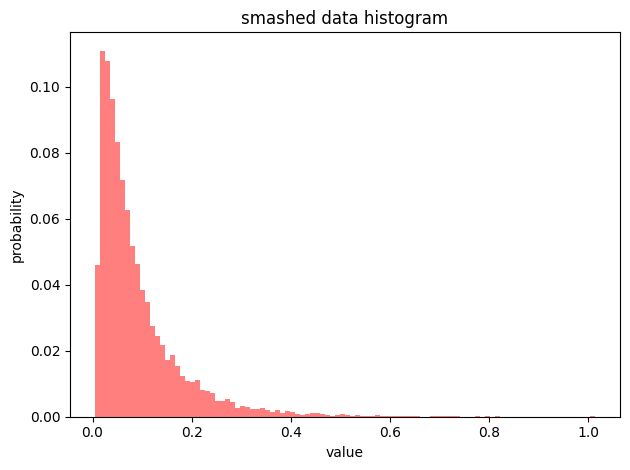

sigma(prob): 0.9999999999999999
counts[0],counts[-1],counts[49] 0.046 9.999999999999912e-05 0.0004000000000000009


In [7]:
# 打印指标分布，观察指标情况
# print 指标分布
mse_df = sim_df['mse'].to_numpy() # mse 
# mse_df = sim_df['2'].to_numpy() # 1.0/dFIL
plot_array_distribution(mse_df,start=-1, end=1)

In [10]:
# 提取出cos<0.4和cos>0.6的样本，生成两个df 

# 1.找索引
index_low = mse_df<0.1
index_high = mse_df>0.1

print('小组中的数据索引：', index_low)
print('大组中的数据索引：', index_high)

# 2. 提取出cifar10中对应的数据，形成两个数据集dataloader


# 3. 构建pair data




# 创建新的空DataFrame，用于存储满足条件的行  
# purchase
# df_low = inv_df[sim_df['mse'] < 0.1]  
# df_high = inv_df[sim_df['mse'] > 0.1]  

# 打印结果  
# print("df1中cos值小于的样本:")  
# print(df_low.shape)  
# print("\n df1中cos值大于的样本:")  
# print(df_high.shape)


小组中的数据索引： [ True  True  True ... False  True  True]
大组中的数据索引： [False False False ...  True False False]
(6935,)
(10000,)
